In [2]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 223.6 MB 3.6 kB/s  eta 0:00:01
     |████████████████████████████████| 201.3 MB 14 kB/s /s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
import joblib

## Step 1: Load the features dataset

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
features_df = pd.read_csv("evse_features.csv")

# Display the first few rows of the feature DataFrame to understand the structure
print("\nFeature DataFrame (first 5 rows):")
features_df.head()


Feature DataFrame (first 5 rows):


,sample_index,Scenario,instructions,cpu-migrations,mem_access_rd,mem_access_wr,cache-misses,L1-icache-loads,dTLB-store-misses
0,0,Attack,4.842734e+08,0.0,182447274.0,157319220.0,2113406.0,245241558.0,127193.0
1,1,Attack,3.360893e+08,0.0,83614575.0,51690301.0,1521862.0,213434196.0,161965.0
2,2,Attack,2.504586e+08,0.0,62673568.0,123802350.0,1212126.0,69182309.0,18750.0
3,3,Attack,3.815842e+08,0.0,61085549.0,49477220.0,681121.0,158026571.0,226431.0
4,4,Attack,2.012276e+09,0.0,464448105.0,344314102.0,11346447.0,943011302.0,776176.0


## Step 2: Encode the Target Variable (Scenario) for Binary Classification

In [3]:
# Encode the target variable (Scenario) into binary values (0: Benign, 1: Attack)
le = LabelEncoder()
y = le.fit_transform(features_df['Scenario'].apply(lambda x: 'Attack' if x != 'Benign' else 'Benign'))

# Display the encoded labels
print("Encoded labels:", dict(zip(le.classes_, range(len(le.classes_)))))

Encoded labels: {'Attack': 0, 'Benign': 1}


## Step 3: Prepare Feature Matrix (X) and Target Vector (y)

In [4]:
# Select feature columns (exclude sample_index and Scenario)
X = features_df.drop(columns=['sample_index', 'Scenario'])

# Display the feature matrix
X.head()

,instructions,cpu-migrations,mem_access_rd,mem_access_wr,cache-misses,L1-icache-loads,dTLB-store-misses
0,4.842734e+08,0.0,182447274.0,157319220.0,2113406.0,245241558.0,127193.0
1,3.360893e+08,0.0,83614575.0,51690301.0,1521862.0,213434196.0,161965.0
2,2.504586e+08,0.0,62673568.0,123802350.0,1212126.0,69182309.0,18750.0
3,3.815842e+08,0.0,61085549.0,49477220.0,681121.0,158026571.0,226431.0
4,2.012276e+09,0.0,464448105.0,344314102.0,11346447.0,943011302.0,776176.0


## Step 4: Split Data into Training and Test Sets

In [5]:
# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Print the sizes of the training and test sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 5928 samples
Test set size: 2541 samples


## Step 5: Define XGBoost Model

In [6]:
# Define the XGBoost model for binary classification (Attack vs. Benign)
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',  # Log loss for binary classification
    random_state=42
)

## Step 6: K-Fold Cross-Validation

In [7]:
# Initialize KFold with 5 splits for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Perform cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train the model on this fold
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predict and evaluate on the validation fold
    y_val_pred = xgb_model.predict(X_val_fold)
    fold_accuracy = (y_val_pred == y_val_fold).mean()
    cv_scores.append(fold_accuracy)

# Print cross-validation scores
print(f"\nK-Fold Cross-Validation Scores (XGBoost): {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.3f} (+/- {np.std(cv_scores) * 2:.3f})")


K-Fold Cross-Validation Scores (XGBoost): [0.9780775716694773, 0.9637436762225969, 0.9662731871838112, 0.9746835443037974, 0.9696202531645569]
Mean CV Accuracy: 0.970 (+/- 0.011)


## Step 7: Train the Model on Full Training Set

In [8]:
# Train the model on the full training set
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Step 8: Make Predictions and Evaluate the Model


Classification Report (XGBoost):
              precision    recall  f1-score   support

      Attack       0.98      0.97      0.97      1850
      Benign       0.92      0.94      0.93       691

    accuracy                           0.96      2541
   macro avg       0.95      0.95      0.95      2541
weighted avg       0.96      0.96      0.96      2541



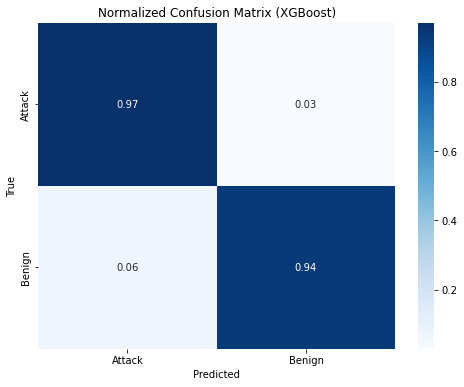

In [11]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Classification report for binary classification (Attack vs. Benign)
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (XGBoost)')
plt.show()

## Step 9: Feature Importance


Feature Importance:
             Feature  Importance
0       instructions    0.636632
4       cache-misses    0.180994
3      mem_access_wr    0.052249
1     cpu-migrations    0.042208
6  dTLB-store-misses    0.036679
5    L1-icache-loads    0.027752
2      mem_access_rd    0.023485


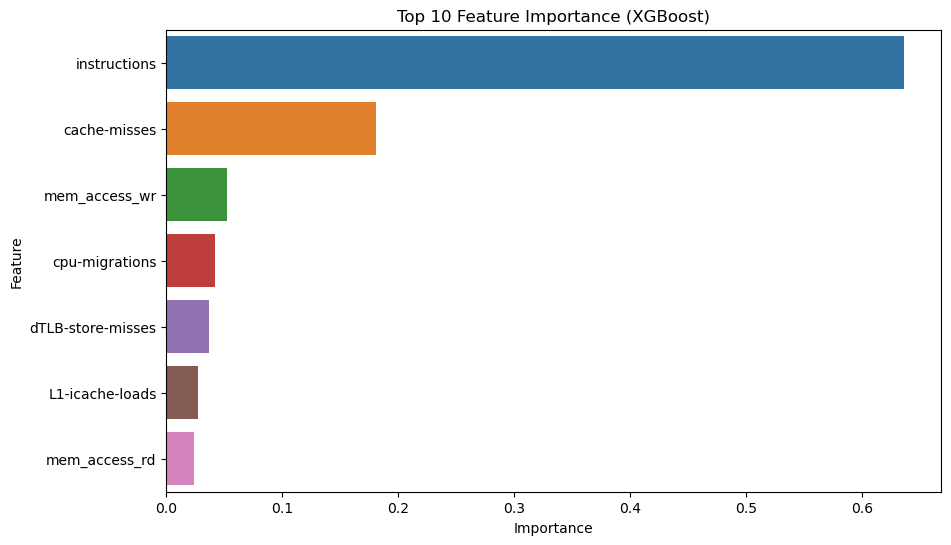

In [11]:
# Feature importance from the trained XGBoost model
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("\nFeature Importance:")
print(feature_importance)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance (XGBoost)')
plt.show()

## Step 10: Compute ROC Curve & AUC Score

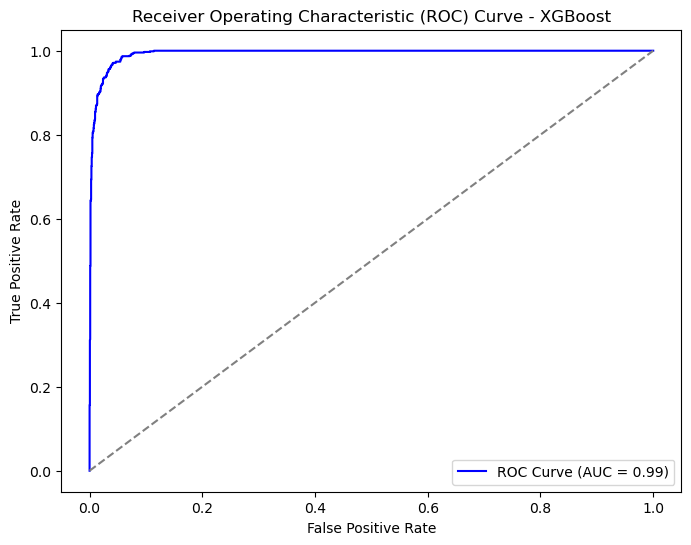

In [12]:
# Get predicted probabilities for positive class (Attack)
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()

## Step 12: Compute Precision-Recall Curve

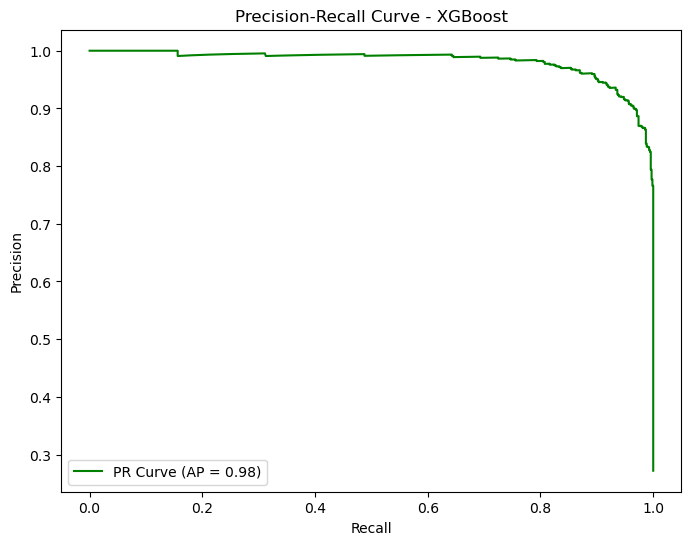

In [13]:
# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend(loc='lower left')
plt.show()


## Step 13: Save the Model and Label Encoder

In [14]:
# Save the trained model and label encoder for future use
joblib.dump(xgb_model, 'xgboost_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']